# MNIST Digit Classification with our own Framework

Lab Assignment from [AI for Beginners Curriculum](https://github.com/microsoft/ai-for-beginners).

### Reading the Dataset


In [4]:
import gzip
import pickle

with gzip.open('../../../data/mnist.pkl.gz', 'rb') as mnist_pickle:
    MNIST = pickle.load(mnist_pickle)

In [5]:
labels = MNIST['Train']['Labels']
data = MNIST['Train']['Features']

Let's see what is the shape of data that we have:

In [6]:
data.shape

(42000, 784)

### Splitting the Data

We will use Scikit Learn to split the data between training and test dataset:

In [7]:
from sklearn.model_selection import train_test_split

features_train, features_test, labels_train, labels_test = train_test_split(data,labels,test_size=0.2)

print(f"Train samples: {len(features_train)}, test samples: {len(features_test)}")

Train samples: 33600, test samples: 8400


### Instructions

1. Take the framework code from the lesson and paste it into this notebook, or (even better) into a separate Python module
1. Define and train one-layered perceptron, observing training and validation accuracy during training
1. Try to understand if overfitting took place, and adjust layer parameters to improve accuracy
1. Repeat previous steps for 2- and 3-layered perceptrons. Try to experiment with different activation functions between layers.
1. Try to answer the following questions:
    - Does the inter-layer activation function affect network performance?
    - Do we need 2- or 3-layered network for this task?
    - Did you experience any problems training the network? Especially as the number of layers increased.
    - How do weights of the network behave during training? You may plot max abs value of weights vs. epoch to understand the relation.

In [8]:
%matplotlib widget
import pylab
import numpy as np

features_train을  확인한다.  (from Perceptron.ipynb)

  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1  79 156 255 231  94   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   2  80 181 254 254 254 251 227   6   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   2  53 137 193 254 254 254 246 164  59  47   3   0 

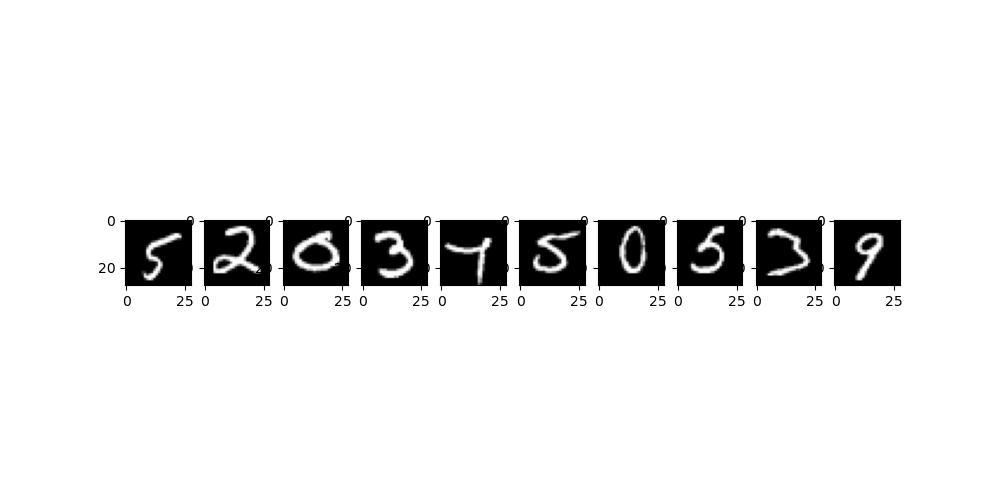

In [9]:
# 첫 번째 data의 내용을 보기 좋게 출력한다.
matrix = features_train[0].reshape(28, 28) 
for i in range(matrix.shape[0]):
    print(' '.join(format(x, '3') for x in matrix[i, :28]))
print(labels_train[0])

fig = pylab.figure(figsize=(10,5))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    pylab.imshow(features_train[i].reshape(28,28), cmap="gray")
pylab.show()

OwnFramework.ipynb에서 코드를 가져온다.

In [7]:
class Linear:
    def __init__(self,nin,nout):
        self.W = np.random.normal(0, 1.0/np.sqrt(nin), (nout, nin))
        self.b = np.zeros((1,nout))
        self.dW = np.zeros_like(self.W)
        self.db = np.zeros_like(self.b)
        
    def forward(self, x):
        self.x=x
        return np.dot(x, self.W.T) + self.b
    
    def backward(self, dz):
        dx = np.dot(dz, self.W)
        dW = np.dot(dz.T, self.x)
        db = dz.sum(axis=0)
        self.dW = dW
        self.db = db
        return dx
    
    def update(self,lr):
        self.W -= lr*self.dW
        self.b -= lr*self.db

class Softmax:
    def forward(self,z):
        self.z = z
        zmax = z.max(axis=1,keepdims=True)
        expz = np.exp(z-zmax)
        Z = expz.sum(axis=1,keepdims=True)
        return expz / Z
    def backward(self,dp):
        p = self.forward(self.z)
        pdp = p * dp
        return pdp - p * pdp.sum(axis=1, keepdims=True)
    
class CrossEntropyLoss:
    def forward(self,p,y):
        self.p = p
        self.y = y
        p_of_y = p[np.arange(len(y)), y]
        log_prob = np.log(p_of_y + 1e-9) # 작은 값 추가로 로그(0) 방지
        return -log_prob.mean()
    def backward(self,loss):
        dlog_softmax = np.zeros_like(self.p)
        dlog_softmax[np.arange(len(self.y)), self.y] -= 1.0/len(self.y)
        return dlog_softmax / (self.p + 1e-9)

class Tanh:
    def forward(self,x):
        y = np.tanh(x)
        self.y = y
        return y
    def backward(self,dy):
        return (1.0-self.y**2)*dy

class Net:
    def __init__(self):
        self.layers = []
    
    def add(self,l):
        self.layers.append(l)
        
    def forward(self,x):
        for l in self.layers:
            x = l.forward(x)
        return x
    
    def backward(self,z):
        for l in self.layers[::-1]:
            z = l.backward(z)
        return z
    
    def update(self,lr):
        for l in self.layers:
            if 'update' in l.__dir__():
                l.update(lr)

def get_loss_acc(x,y,loss=CrossEntropyLoss()):
    p = net.forward(x)
    l = loss.forward(p,y)
    pred = np.argmax(p,axis=1)
    acc = (pred==y).mean()
    return l,acc

def train_epoch(net, train_x, train_labels, loss=CrossEntropyLoss(), batch_size=32, lr=0.1):
    for i in range(0,len(train_x),batch_size):
        xb = train_x[i:i+batch_size]
        yb = train_labels[i:i+batch_size]

        p = net.forward(xb)
        l = loss.forward(p,yb)
        dp = loss.backward(l)
        dx = net.backward(dp)
        net.update(lr)

In [8]:
net = Net()
net.add(Linear(784,10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
train_epoch(net, features_train, labels_train, batch_size=84, lr=0.1)      
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(features_test, labels_test)))

Initial loss=18.92050871030782, accuracy=0.06922619047619048: 
Final loss=18.679310390906103, accuracy=0.09863095238095237: 
Test loss=18.692879195919044, accuracy=0.09797619047619048: 


네트워크 디자인의 기준을 아래와 같이 설명할 수 있습니다.

1. 네트워크 깊이와 너비의 설정 기준

네트워크 너비 (Layer Width): 레이어의 너비는 해당 레이어에서 활성화되는 뉴런의 수를 의미합니다. 너비가 넓을수록 모델은 더 많은 특성을 학습할 수 있지만, 계산 비용과 과적합의 위험도 증가합니다.
네트워크 깊이 (Layer Depth): 깊은 네트워크는 복잡한 패턴을 학습할 수 있는 능력이 향상되지만, 깊어질수록 학습이 어려워지고, 기울기 소실 문제(Gradient Vanishing)나 기울기 폭발(Gradient Exploding)이 발생할 수 있습니다.

2. 중간 레이어의 역할

특성 변환: 중간 레이어는 입력된 원시 데이터를 고차원 공간으로 매핑하여, 원래의 선형적으로 구분되지 않는 문제를 더 잘 구분할 수 있는 형태로 변환합니다. 예를 들어, XOR 문제는 선형적으로 구분할 수 없지만, 특정 변환을 거치면 선형 분류기로도 해결할 수 있습니다.
학습 가능한 특성의 확장: 초기 입력의 784개 특성만으로는 충분한 패턴을 학습하기 어려울 수 있습니다. 따라서, 그 이상의 뉴런으로 확장하는 것은 모델이 더 많은 내부 표현을 학습하고 복잡한 함수를 모델링할 수 있게 합니다.

3. 합리적인 설정의 기준

과적합 대비: 중간 레이어의 너비를 너무 크게 설정하면 학습 데이터에 대해 과적합될 수 있습니다. 적절한 크기의 레이어를 선택하는 것은 실험을 통해 결정되며, 교차 검증과 같은 기법을 사용하여 최적화할 수 있습니다.
성능 및 계산 효율: 너무 많은 뉴런은 계산 비용을 증가시키고 학습 시간을 늘립니다. 하드웨어의 제한과 요구되는 응답 시간을 고려하여 적절한 너비를 선택하는 것이 중요합니다.
문제의 복잡성: 문제의 복잡성에 따라 레이어의 너비를 조정할 수 있습니다. 예를 들어, 간단한 분류 문제는 적은 수의 뉴런으로도 충분할 수 있으나, 이미지 인식과 같은 복잡한 문제는 더 많은 뉴런을 요구합니다.

In [430]:
# 설정에 따른 테스트 데이터 정확도
middle, batch_size, lr = 112, 420, 0.05 # 0.85
middle, batch_size, lr = 196, 420, 0.05 # 0.87
middle, batch_size, lr = 392, 420, 0.05 # 0.88
middle, batch_size, lr = 784, 420, 0.05 # 0.90
middle, batch_size, lr = 1568, 420, 0.05 # 0.91
middle, batch_size, lr = 2352, 420, 0.05 # 0.91
middle, batch_size, lr = 1568, 210, 0.05 # 0.91
middle, batch_size, lr = 1568, 840, 0.05 # 0.90
middle, batch_size, lr = 1568, 105, 0.05 # 0.87
middle, batch_size, lr = 1568, 210, 0.01 # 0.89
middle, batch_size, lr = 1568, 210, 0.1 # 0.75
middle, batch_size, lr = 1568, 210, 0.03 # 0.91
middle, batch_size, lr = 2000, 210, 0.035 # 0.91
middle, batch_size, lr = 2352, 210, 0.035 # 0.92

#
# 입력, 출력 수는 유지하면서 히든 레이어의 입출력수는 조정하면서 테스트한다.
#
net = Net()
net.add(Linear(784,middle))
net.add(Tanh())
net.add(Linear(middle,10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
train_epoch(net, features_train, labels_train, batch_size=batch_size, lr=lr)      
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(features_test, labels_test)))

Initial loss=2.686084648578906, accuracy=0.11770833333333333: 
Final loss=0.2619463161602424, accuracy=0.9241964285714286: 
Test loss=0.2841287442660595, accuracy=0.9147619047619048: 


### 레이어 추가
앞의 모델에 Linear, Tanh를 추가해 보았다.
정확도가 크게 향상되지는 않는다.

In [9]:
# 설정에 따른 테스트 데이터 정확도
middle1, middle2, batch_size, lr = 784, 1568, 420, 0.03 # 0.89
middle1, middle2, batch_size, lr = 2352, 1568, 210, 0.03 # 0.91
middle1, middle2, batch_size, lr = 1568, 1568, 210, 0.035 # 0.91
middle1, middle2, batch_size, lr = 2352, 4704, 420, 0.035 # 0.91
middle1, middle2, batch_size, lr = 1568, 2352, 210, 0.035 # 0.92
middle1, middle2, batch_size, lr = 2352, 4704, 210, 0.035 # 0.92

net = Net()
net.add(Linear(784,middle1))
net.add(Tanh())
net.add(Linear(middle1,middle2))
net.add(Tanh())
net.add(Linear(middle2,10))
net.add(Softmax())
loss = CrossEntropyLoss()

print("Initial loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
train_epoch(net, features_train, labels_train, batch_size=batch_size, lr=lr)      
print("Final loss={}, accuracy={}: ".format(*get_loss_acc(features_train, labels_train)))
print("Test loss={}, accuracy={}: ".format(*get_loss_acc(features_test, labels_test)))

Initial loss=2.385318821406313, accuracy=0.12220238095238095: 
Final loss=0.22025424161485002, accuracy=0.9394642857142858: 
Test loss=0.2555423024391184, accuracy=0.9267857142857143: 
